<a href="https://colab.research.google.com/github/AnimeshBanik144/the-phiQKD-protocol-codes/blob/main/Generalized_state_discrimination.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install qiskit[visualization]
%pip install qiskit_aer

In [3]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import RYGate, RXGate, RZGate
from qiskit_aer import AerSimulator
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Function for finding the orthogonal of a vector
def ortho(vector):
  return np.array([np.conj(vector[1]), -np.conj(vector[0])])

In [5]:
# Function for getting the tilted or prime states
def get_prime(vec_a, vec_b, theta):
    vec_a = np.array(vec_a)
    vec_b = np.array(vec_b)
    cos_alpha = np.abs(vec_a.conj().T @ vec_b)
    alpha = np.arccos(cos_alpha)
    p = (np.cos(-theta) - (np.cos(alpha) * np.cos(alpha + theta))) / (np.sin(alpha)) ** 2
    q = (np.cos(alpha + theta) - (np.cos(alpha) * np.cos(-theta))) / (np.sin(alpha)) ** 2
    return (p * vec_a) + (q * vec_b), (q * vec_a) + (p * vec_b)

In [6]:
# Define the computational basis states
zero_ket = np.array([1, 0])
one_ket = np.array([0, 1])
# Define the signal states |0> and |+>
psi_1 = zero_ket
psi_2 = Statevector([1, 0]).evolve(RYGate(45 * np.pi / 180 * 2)).data


In [7]:
def loop_body(psi, phi, angle):
  psi_prime, phi_prime = get_prime(psi, phi, angle)

  psi_prime_ortho = ortho(psi_prime)
  phi_prime_ortho = ortho(phi_prime)

  phi_psi_bracket = phi.conj().T @ psi
  phi_prime_psi_prime_bracket = phi_prime.conj().T @ psi_prime

  # gamma
  c_phi = np.exp(1j * np.angle(phi_prime_psi_prime_bracket))
  c_gamma = 1 / np.sqrt(2 * (1 + np.abs(phi_prime_psi_prime_bracket)))
  gamma = c_gamma * (psi_prime + (c_phi * phi_prime))

  # F_psi
  c_F_psi = 1 / (1 + np.abs(phi_prime_psi_prime_bracket))
  phi_ortho_outer = np.outer(phi_prime_ortho, phi_prime_ortho.conj().T)
  F_psi = c_F_psi * phi_ortho_outer

  # F_phi
  c_F_phi = 1 / (1 + np.abs(phi_prime_psi_prime_bracket))
  psi_ortho_outer = np.outer(psi_prime_ortho, psi_prime_ortho.conj().T)
  F_phi = c_F_phi * psi_ortho_outer

  # F_unknown
  c_F_unknown = (2 * np.abs(phi_prime_psi_prime_bracket)) / (1 + np.abs(phi_prime_psi_prime_bracket))
  gamma_outer = np.outer(gamma, gamma.conj().T)
  F_unknown = c_F_unknown * gamma_outer

  pp = np.trace(np.outer(psi, psi.conj().T) @ F_psi)
  pe = np.trace(np.outer(psi, psi.conj().T) @ F_phi)
  pq = np.trace(np.outer(psi, psi.conj().T) @ F_unknown)

  return pp, pe, pq



In [8]:
theta = np.arccos(psi_1.conj().T @ psi_2)
phi_helstrom = (np.pi / 2 - theta) / 2
phi = 0.04363323129985824

psi_1_prime, psi_2_prime = get_prime(psi_1, psi_2, phi)
psi_1_prime_ortho = ortho(psi_1_prime)
psi_2_prime_ortho = ortho(psi_2_prime)

psi_2_psi_1_bracket = psi_2.conj().T @ psi_1
psi_2_prime_psi_1_prime_bracket = psi_2_prime.conj().T @ psi_1_prime

# gamma
c_phi = np.exp(1j * np.angle(psi_2_prime_psi_1_prime_bracket))
c_gamma = 1 / np.sqrt(2 * (1 + np.abs(psi_2_prime_psi_1_prime_bracket)))
gamma = c_gamma * (psi_1_prime + (c_phi * psi_2_prime))

# F_psi
c_F_psi = 1 / (1 + np.abs(psi_2_prime_psi_1_prime_bracket))
psi_2_ortho_outer = np.outer(psi_2_prime_ortho, psi_2_prime_ortho.conj().T)
F_psi = c_F_psi * psi_2_ortho_outer
f_psi = np.sqrt(c_F_psi) * psi_2_prime_ortho

# F_phi
c_F_phi = 1 / (1 + np.abs(psi_2_prime_psi_1_prime_bracket))
psi_1_ortho_outer = np.outer(psi_1_prime_ortho, psi_1_prime_ortho.conj().T)
F_phi = c_F_phi * psi_1_ortho_outer
f_phi = np.sqrt(c_F_phi) * psi_1_prime_ortho

# F_unknown
c_F_unknown = (2 * np.abs(psi_2_prime_psi_1_prime_bracket)) / (1 + np.abs(psi_2_prime_psi_1_prime_bracket))
gamma_outer = np.outer(gamma, gamma.conj().T)
F_unknown = c_F_unknown * gamma_outer
f_unknown = np.sqrt(c_F_unknown) * gamma

f_all_zeros = np.array([0, 0])

oo = np.kron(zero_ket, zero_ket)
oi = np.kron(zero_ket, one_ket)
io = np.kron(one_ket, zero_ket)
ii = np.kron(one_ket, one_ket)

i_s = [oo, oi, io, ii]
f_s = [f_psi, f_phi, f_unknown, f_all_zeros]

V = np.array([np.outer(a, b.conj().T) for a, b in zip(i_s, f_s)]).sum(axis=0)

Q, R = np.linalg.qr(np.array([V @ zero_ket, V @ one_ket, [0, 0, 1, 0], [0, 0, 0, 1]]).T, 'complete')
U = Q * np.sign(np.diag(R))

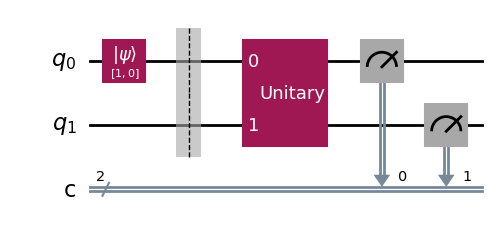

In [9]:
qc = QuantumCircuit(2, 2)
qc.initialize(psi_1, 0)
qc.barrier()
qc.unitary(U, [0, 1])
qc.measure([0, 1], [0, 1])

qc.draw(output='mpl')

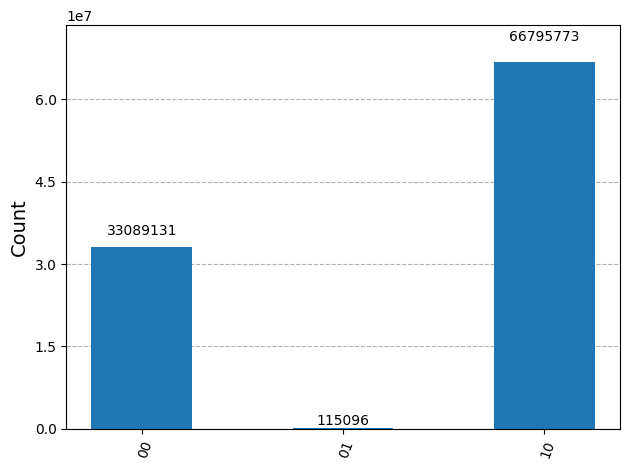

In [10]:
aersim = AerSimulator()
qc = transpile(qc, aersim)
job = aersim.run(qc, shots=100000000)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

In [11]:
print('Ps =',(1 / (1 + (psi_1_prime.conj().T @ psi_2_prime))) * (np.cos((np.pi / 2) + theta + (phi)) ** 2))
print('Pe =',(1 / (1 + (psi_1_prime.conj().T @ psi_2_prime))) * (np.cos((np.pi / 2) - (phi)) ** 2))

cos_line = c_gamma * (np.cos(phi) + (np.cos(theta + phi)))
cos_line_conj = np.conj(cos_line)

print('Pq =',c_F_unknown * cos_line_conj * cos_line)

Ps = (0.3308874915836193+0j)
Pe = (0.0011581843830014516+0j)
Pq = (0.6679543240333795+0j)


$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$

- If we get $\ket{10}$ then we don't get any meaningful information and so cannot discriminate the states. We call these the inconclusive outcomes.
- If we get $\ket{00}$ then we can say that the state given must be $\ket{\psi_{1}}$ although with some error probability. The same can be said for the case of $\ket{01}$ which represents $\ket{\psi_{2}}$.

Thus we can calculate the accuracy($\chi$)[Probability of correct detection among the conclusive outcomes], and efficiency($\zeta$)[Probability of conclusive detection] as follows:
\begin{equation}
    \begin{aligned}
        \chi &= \frac{P_s \times 100}{1 - P_q} , \\
        \zeta &= (1 - P_q) \times 100 .
    \end{aligned}
\end{equation}

We have accomplished a general case of POVM (only applicable in the zx plane) with some tolerance which when pushed to extremes gives us the "IDP limit" and the "Helstrom-Holevo bound probabilty".

Note:
- Ivanovic-Diek-Peres(IDP) Limit:<br>
Probability of discrimination, Pd = 1 - $|\bra{\psi_{2}}{\psi_{1}\rangle}|$
- Helstrom-Holevo Bound:<br>
Probibility of success, Ps = $(1/2)(1 + sin\theta)$